
# Libraries

In [176]:
# Standard Libraries
import os
import re
import json
import time
import string
import warnings
from dotenv import load_dotenv
import os
from openai import OpenAI
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup

# Third-Party Libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from IPython.display import clear_output

# Scientific and Computational Libraries
from scipy.spatial import ConvexHull
from scipy import interpolate

# NLP Libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from langdetect import detect_langs

# Text Processing Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Machine Learning Libraries
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Dimensionality Reduction and Clustering Libraries
import umap
import hdbscan

# Custom/Other Libraries
from pointgrid import align_points_to_grid

# Polarization Libraries
import nltk
from nltk.corpus import opinion_lexicon

# Data Cleaning

In [153]:
# Load the dataset
df = pd.read_csv("data.csv")
initial_rows = df.shape[0]

In [154]:
# Clean: drop unnecessary columns and reset index
df = df.drop(['contentMarketingPublisher',  # There are two empty columns 'contentMarketingPublisher', 'summary_shot_title'
              'summary_shot_title',         # 'type' has only one value in all rows = 'article'
              'type', 
              'created'],                   # 'created' and 'published' dates aren't too disimilar, for simplicity published will be kept
              axis=1)
df = df.reset_index(drop=True)

# Remove rows with NaN values
df = df.dropna(subset=['id'])               # Remove rows where 'id' is NaN (Total of 37 rows)
df = df.dropna(subset=['bodytext'])         # Remove rows where 'bodytext' is NaN (Total of 40 rows)

# Repalce rows with NaN values (There are still 407 rows with no subtitles.)
df['subtitle'] = df['subtitle'].fillna(df['title']) # 'Title' will be used to fill in 'subtitle' with NaN.


df['published'] = df['published'].str.strip() # Clean the 'published' column: trim whitespace and ensure it's a valid datetime
df['published'] = pd.to_datetime(df['published'], errors='coerce', utc=True) # Convert with utc=True to handle mixed time zones
df['year'] = df['published'].dt.year # Extract the year from the 'published' column
df['month'] = df['published'].dt.month # Extract the month from the 'published' column
df['day'] = df['published'].dt.day # Extract the day from the 'published' column

# Change data types to strings and integers
df = df.astype({
    'bodytext': str,        # bodytext to stirng
    'created_by_name': str, # created_by_name to string,
    'id': int,              # id to integer
    'published_url': str,   # published_url to string,
    'subtitle': str,        # subtitle	to strings
    'tags': str,            # tags	to strings
    'title': str,           # title	to strings
    'year': int,            # year to integer
    'month': int,           # month to integer
    'day': int              # day to integer
})

# Correcting Names in 'creator' column
name_corrections = {
    "Nagell Ylisåker, Line": "Nagell Ylvisåker, Line",
    "Markussen Hansen, Anja Charlotte": "Markussen, Anja Charlotte"
}
df["created_by_name"] = df["created_by_name"].replace(name_corrections)

# Display dataset statistics
print(f'Initial number of rows before cleaning {initial_rows}\n')
print(f"The dataset contains {df.shape[0]} articles after cleaning\n")

# Sample a few rows for inspection
df.sample(5)

Initial number of rows before cleaning 16786

The dataset contains 16709 articles after cleaning



,bodytext,created_by_name,id,published,published_url,subtitle,tags,title,year,month,day
7914,– Å være tilstede ved sykehustrappa der alle s...,"Woldbrand Guldstad, Alexander",178231,2019-03-19 09:55:00+00:00,/folk/fikk-drommejobben/178231,"Hun kom på soldagen, hadde aldri vært nord for...","svalbardliv, folk",Fikk Drømmejobben,2019,3,19
488,Sysselmesteren ber i et brev datert 21. mai Tr...,"Nagell Ylvisåker, Line",536825,2024-06-04 13:26:18+00:00,/far-tre-uker-pa-a-fjerne-korset-soker-om-ny-p...,Trust Arktikugol skal fjerne det ortodokse kor...,nyheter,Får tre uker på å fjerne korset - søker om ny ...,2024,6,4
8088,"Sam og Avaz Ziaei var fornøyd, men spent da de...","Woldbrand Guldstad, Alexander",176617,2019-01-31 05:00:00+00:00,/gamle-sykehuset/anker-knusende-dom-om-darlig-...,Brødrene Ziaei fikk blankt avslag fra tingrett...,"gamle sykehuset, nyheter",Anker knusende dom om dårlig boligkjøp,2019,1,31
3151,Det har vært uvanlig varmt i mange dager og me...,"Haugli, Børre",485229,2022-06-01 20:00:00+00:00,/en-artig-meteorolog-og-provosert-politiker/48...,En artig meteorolog og provosert politiker,meninger,En artig meteorolog og provosert politiker,2022,6,1
8770,– Det er litt status å kunne kalle seg gruvear...,"Woldbrand Guldstad, Alexander",169588,2018-06-23 05:00:00+00:00,/folk-gruve-gruve-7/da-broren-dode-i-gruva-lov...,Men Bent Jakobsen klarte ikke å være den enest...,"portrettet, nyheter, gruvesikkerhet, gruvebus,...","Da broren døde i gruva, lovet Bent (47) foreld...",2018,6,23


# Exploratory Data Analysis

### Creators

/var/folders/67/t3d316rx7p38ywzdn6dyq2bh0000gn/T/ipykernel_44016/1088671325.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("Dark2", len(unique_years))  # Use a colormap with distinct colors


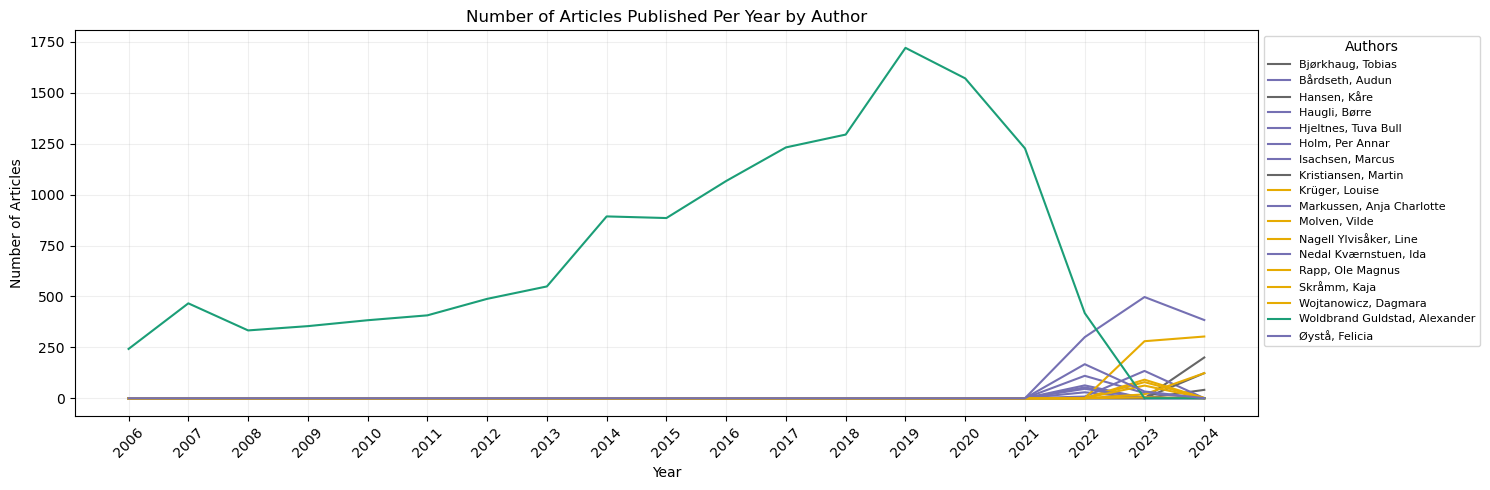

In [155]:
# Grouping data by year and author
author_year_data = df.groupby(["year", "created_by_name"]).size().reset_index(name="article_count")
pivot_df = author_year_data.pivot(index="year", columns="created_by_name", values="article_count").fillna(0)

# Find the first year each author has non-zero articles
first_years = {author: pivot_df[pivot_df[author] > 0].index.min() for author in pivot_df.columns}

# Assign colors based on the first year
unique_years = sorted(set(first_years.values()))  # Unique first years
color_map = cm.get_cmap("Dark2", len(unique_years))  # Use a colormap with distinct colors
year_color_mapping = {year: color_map(i) for i, year in enumerate(unique_years)}

# Pivot data for plotting
pivot_df = author_year_data.pivot(index="year", columns="created_by_name", values="article_count").fillna(0)

# Plotting
plt.figure(figsize=(15, 5))
for author in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[author], label=author, color=year_color_mapping[first_years[author]])

# Annotations & Style
plt.xticks(ticks=pivot_df.index, labels=pivot_df.index.astype(int), rotation=45)
plt.title("Number of Articles Published Per Year by Author")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.legend(title="Authors", loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
plt.grid(alpha = 0.2)

plt.tight_layout()
plt.show()

### Articles

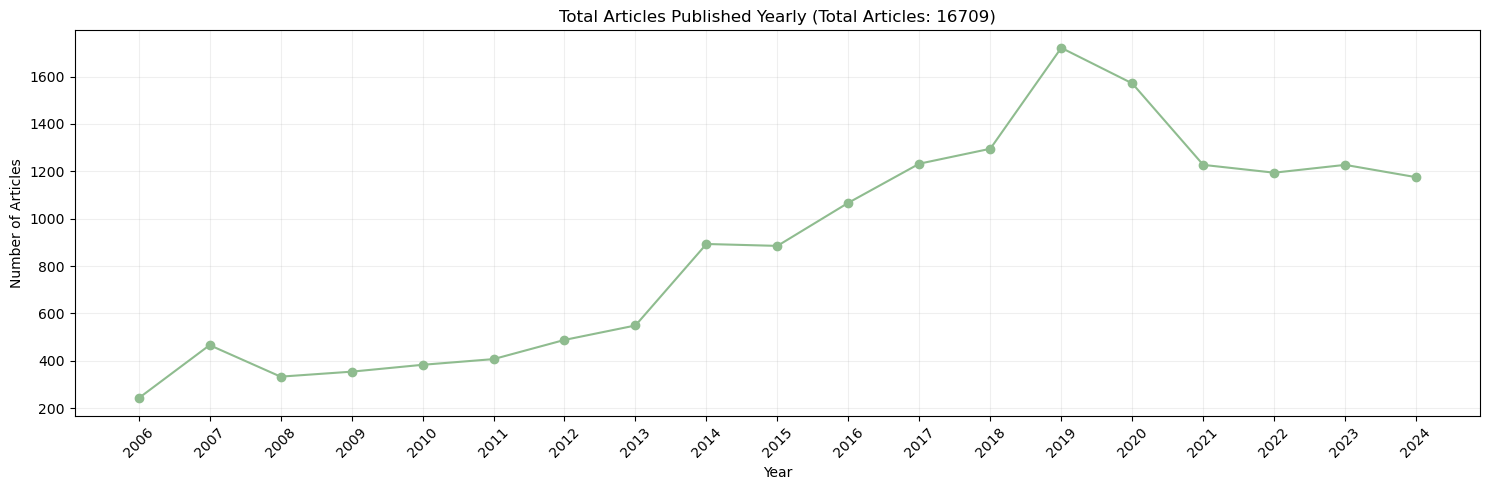

In [156]:
# Plotting Total Articles Published Yearly

# Group the dataframe by year and count the number of articles for each year
articles_per_year = df.groupby('year').size()

# Plot the total publications over time (yearly trend)
plt.figure(figsize=(15, 5))
plt.plot(articles_per_year.index, articles_per_year.values, marker='o', color='darkseagreen', label='Total Articles')

# Calculate the total number of articles
total_articles = articles_per_year.sum()

# Annotations & Style
plt.title(f"Total Articles Published Yearly (Total Articles: {total_articles})")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.xticks(articles_per_year.index, rotation=45)
plt.grid(alpha = 0.2)

plt.tight_layout()
plt.show()

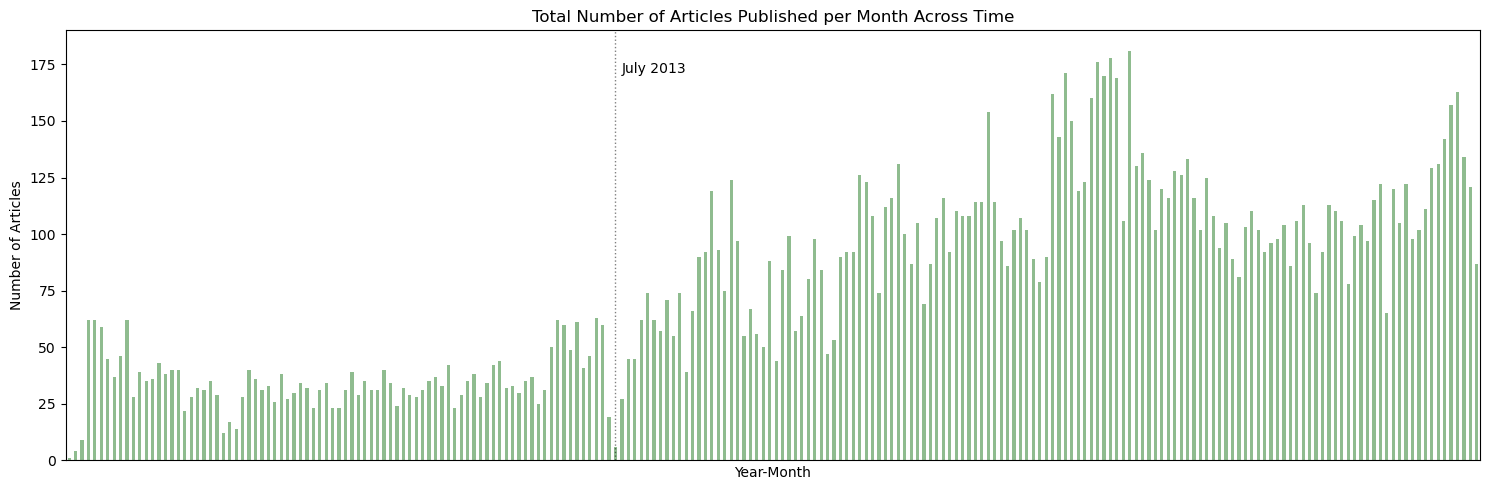

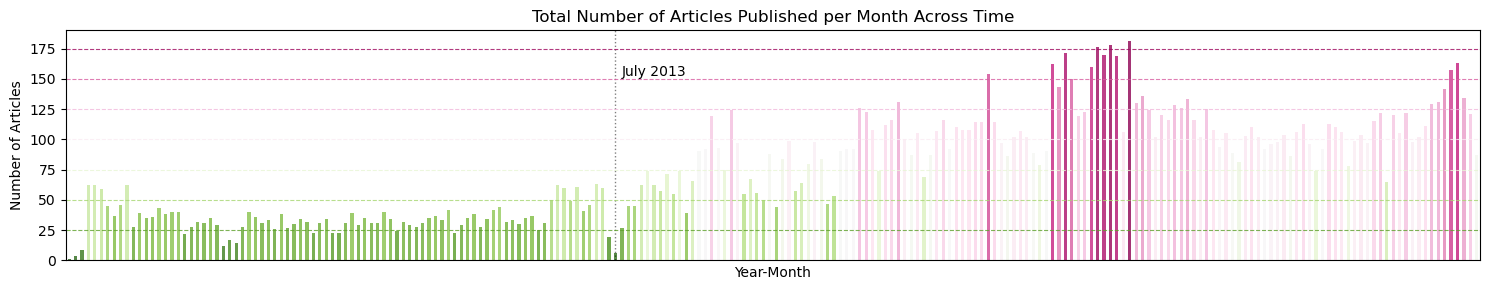

In [157]:
#Plotting Total Number of Articles Published per Month Across Time

# Group the dataframe by both year and month and count the number of articles
articles_per_month_year = df.groupby(['year', 'month']).size()

# Plot Figure 1
plt.figure(figsize=(15, 5))
articles_per_month_year.plot(kind='bar', color='darkseagreen')

# Find the index for July 2013
july_2013_idx = articles_per_month_year.index.get_loc((2013, 7))

# Add vertical line
plt.axvline(x=july_2013_idx, color='black', alpha=0.5, linestyle=':', linewidth=1)
# Add label for the line
plt.text(july_2013_idx + 1, plt.ylim()[1] * 0.9, 'July 2013')

# Add title and labels
plt.title('Total Number of Articles Published per Month Across Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Articles')
plt.xticks([])
plt.tight_layout()
plt.show()

# Plot Figure 2
# Set up colormap
cmap = mpl.colormaps['PiYG_r']
norm = mpl.colors.Normalize(vmin=articles_per_month_year.min(), vmax=articles_per_month_year.max())
colors = [cmap(norm(value)) for value in articles_per_month_year.values]

plt.figure(figsize=(15, 3))
articles_per_month_year.plot(kind='bar', color=colors, alpha=0.8)

# Add vertical line for July 2013
plt.axvline(x=july_2013_idx, color='black', alpha=0.5, linestyle=':', linewidth=1)
# Add label for the line
plt.text(july_2013_idx + 1, plt.ylim()[1] * 0.8, 'July 2013')

plt.title('Total Number of Articles Published per Month Across Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Articles')
plt.xticks([])

# Draw horizontal gridlines
for i in range(25, 176, 25):
    color = cmap(norm(i))
    plt.axhline(y=i, color=color, linewidth=0.8, linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

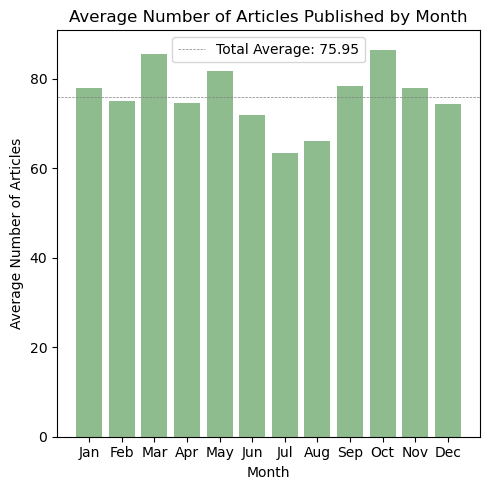

In [158]:
# Plotting Average Number of Articles Published by Month

# Calculate the average number of articles by month
articles_per_year_month = df.groupby(['year', 'month']).size().reset_index(name='article_count')
monthly_avg = articles_per_year_month.groupby('month')['article_count'].mean().reset_index()

# Calculate the average number of articles in all data
overall_avg = articles_per_year_month['article_count'].mean()

# Plot the average number of articles by month
plt.figure(figsize=(5, 5))
plt.bar(monthly_avg['month'], monthly_avg['article_count'], color='darkseagreen')

# Add the total average line using plt.axhline
plt.axhline(overall_avg, color='gray', linewidth = 0.5 ,linestyle='--', label=f'Total Average: {overall_avg:.2f}')

# Add labels and title
plt.title('Average Number of Articles Published by Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Articles')
plt.xticks(monthly_avg['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

### Word Count

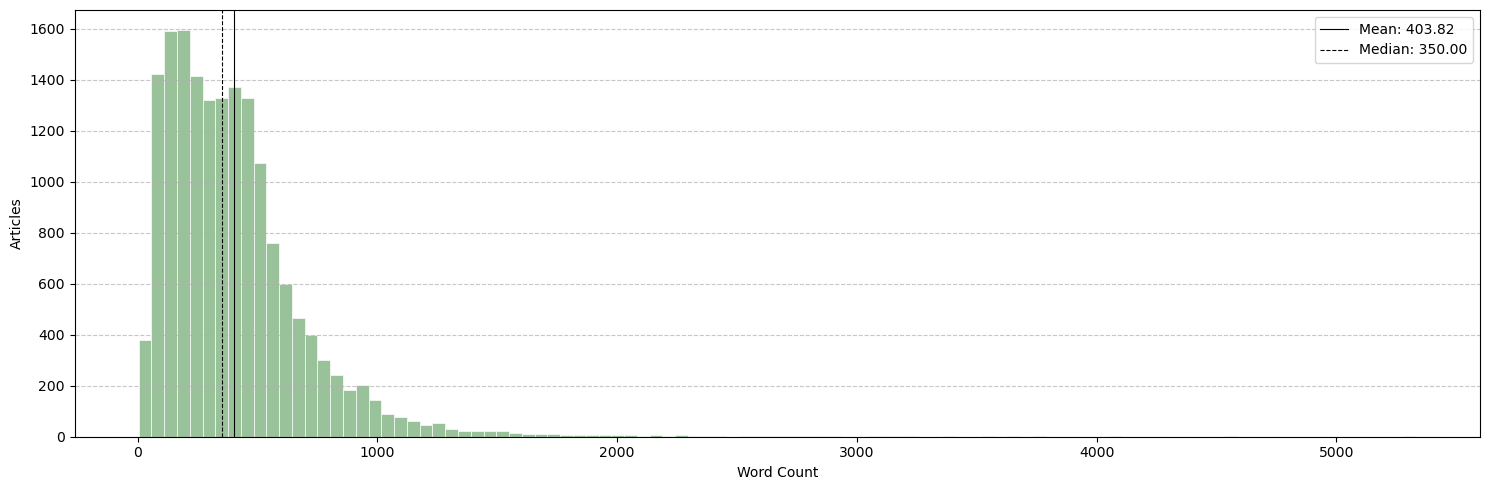

count    16709.000000
mean       403.822371
std        311.287079
min          4.000000
25%        189.000000
50%        350.000000
75%        520.000000
max       5333.000000
Name: word_count, dtype: float64

In [159]:
# Calculate and filter word count
df["word_count"] = df["bodytext"].str.split().str.len()


# Plot histogram
plt.figure(figsize=(15, 5))
plt.hist(df["word_count"], bins=100, color = 'darkseagreen', edgecolor="white", alpha=0.9, linewidth=0.5)
plt.xlabel("Word Count")
plt.ylabel("Articles")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(df['word_count'].mean(),        # Add a vertical line for the mean (solid line)
            color='black', linestyle='-', 
            linewidth=0.8, 
            label=f"Mean: {df['word_count'].mean():.2f}")
plt.axvline(df['word_count'].median(),      # Add a vertical line for the median (dashed line)
            color='black', linestyle='--', 
            linewidth=0.8, 
            label=f"Median: {df['word_count'].median():.2f}")
plt.legend()
plt.tight_layout()
plt.show()

df['word_count'].describe()

Visualizing Trends of Article Length

           Range  Count  Percentage
0       [0, 500)  12084   72.320306
1    [500, 1000)   3987   23.861392
2   [1000, 1500)    469    2.806871
3   [1500, 2000)    104    0.622419
4   [2000, 2500)     33    0.197498
5   [2500, 3000)     15    0.089772
6   [3000, 3500)      9    0.053863
7   [3500, 4000)      5    0.029924
8   [4000, 4500)      1    0.005985
9   [4500, 5000)      1    0.005985
10  [5000, 5500)      1    0.005985




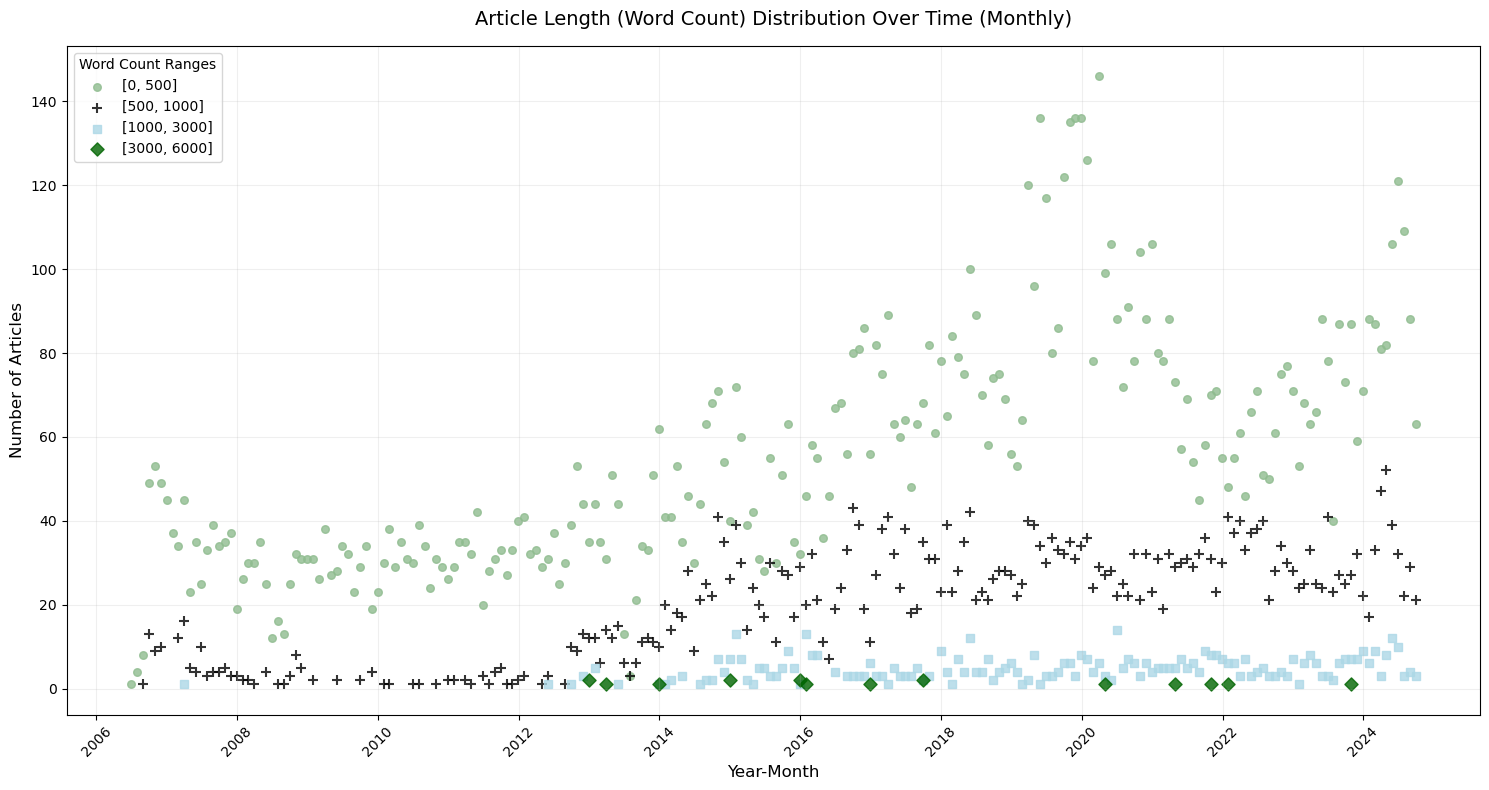


Total articles in each range:
[0, 500]        12104.0
[500, 1000]      3969.0
[1000, 3000]      619.0
[3000, 6000]       17.0
dtype: float64


In [160]:
# Creating specific ranges to see patterns in content production

# Define the bin edges for the word count ranges
bin_edges = list(range(0, df['word_count'].max() + 500, 500))

# Create a new column with the bin category for each word count
df['word_count_range'] = pd.cut(df['word_count'], bins=bin_edges, right=False)

# Count the number of articles in each range
word_count_distribution = df['word_count_range'].value_counts().sort_index()

# Calculate the percentage of articles in each range
word_count_percentage = (word_count_distribution / len(df)) * 100

# Combine into a DataFrame and display
word_count_summary = pd.DataFrame({
    'Range': word_count_distribution.index.astype(str),
    'Count': word_count_distribution.values,
    'Percentage': word_count_percentage.values
})

print('Visualizing Trends of Article Length\n')
print(word_count_summary)
print('\n')


# Create a function to group the word counts into new ranges
def group_word_counts(df):
    ranges = {
        '[0, 500]': (df['word_count'] >= 0) & (df['word_count'] <= 500),
        '[500, 1000]': (df['word_count'] > 500) & (df['word_count'] <= 1000),
        '[1000, 3000]': (df['word_count'] > 1000) & (df['word_count'] <= 3000),
        '[3000, 6000]': (df['word_count'] > 3000) & (df['word_count'] <= 6000)
    }
    
    monthly_data = {}
    for range_name, range_condition in ranges.items():
        monthly_counts = df[range_condition].groupby(pd.Grouper(key='published', freq='ME')).size()
        # Remove zeros
        monthly_counts = monthly_counts[monthly_counts > 0]
        monthly_data[range_name] = monthly_counts
    
    return pd.DataFrame(monthly_data)

# Create the monthly grouped data
monthly_ranges = group_word_counts(df)

# Create the dot plot
plt.figure(figsize=(15, 8))

# Define colors and markers
colors = ['darkseagreen', 'black', 'lightblue', 'darkgreen'] 
markers = ['o', '+', 's', 'D'] # ['o','o','o','o']  # 'o' Circle, 's' Square, '^' Triangle, 'D' Diamond
shape_size = [30, 45, 30, 45]

# Plot only dots
for (column, color, marker, shape_size) in zip(monthly_ranges.columns, colors, markers, shape_size):
    # Get non-null values
    data = monthly_ranges[column].dropna()
    plt.scatter(data.index, data.values, 
               color=color, 
               label=column,
               marker=marker,          
               s=shape_size,                  # Size of markers
               alpha=0.8)             

# Customize the plot
plt.title('Article Length (Word Count) Distribution Over Time (Monthly)', fontsize=14, pad=15)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='-', alpha=0.2)
plt.legend(title='Word Count Ranges', 
          #bbox_to_anchor=(1.05, 1), 
          loc='upper left',
          fontsize=10)

plt.tight_layout()
plt.show()

# Print totals for verification
print("\nTotal articles in each range:")
print(monthly_ranges.sum())


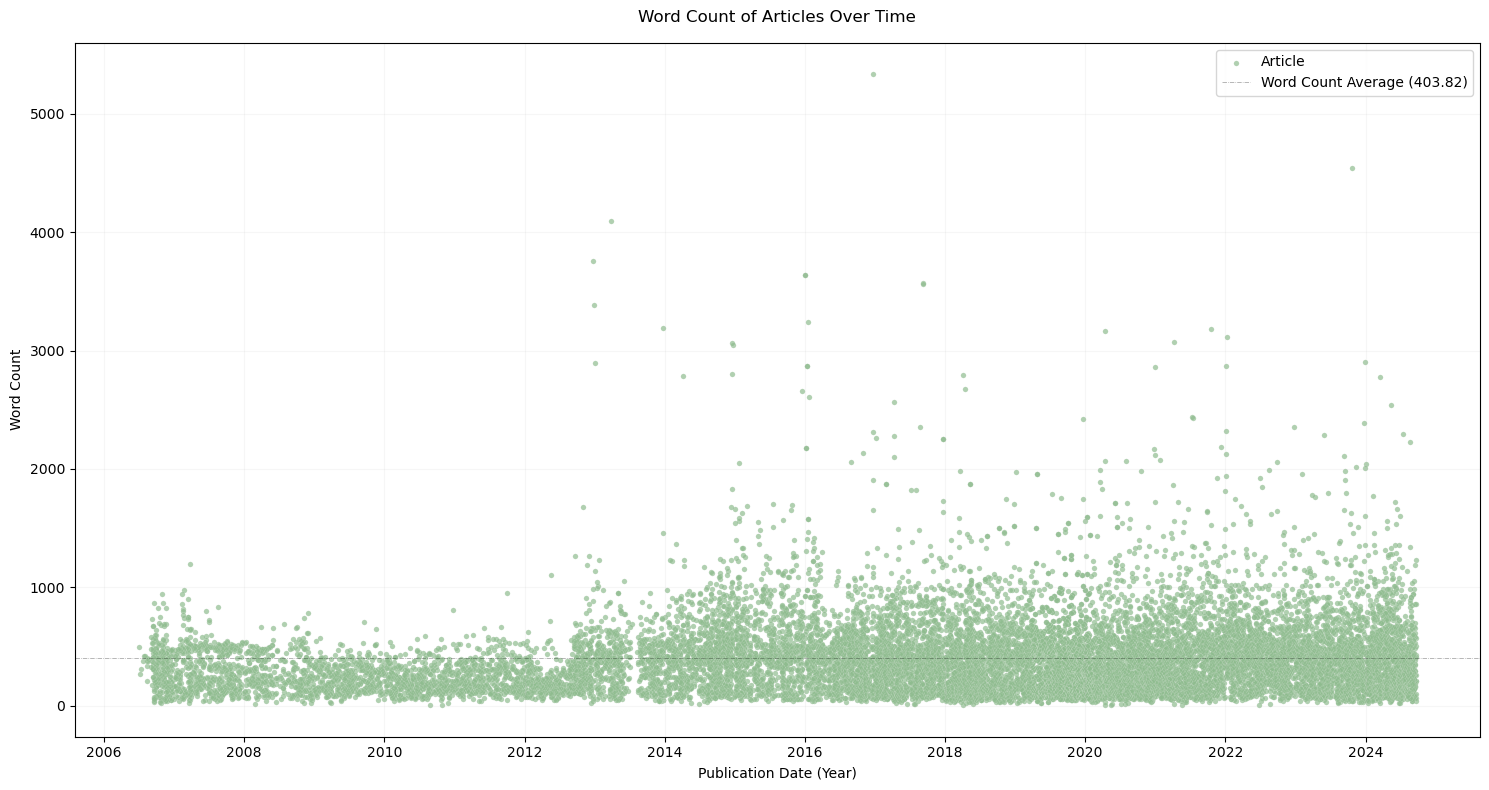

In [161]:
# Create the scatter plot
plt.figure(figsize=(15, 8))

# Plot the word count with small dots
plt.scatter(df['published'],
            df['word_count'],
            s=15,
            edgecolors='white',
            linewidths=0.1,
            alpha=0.7,
            color='darkseagreen',
            label='Article')

# Add the black line for the overall average
plt.axhline(df['word_count'].mean(),
            color='black',
            alpha=0.4,
            linestyle='-.',
            linewidth=0.5,
            label=f'Word Count Average ({df["word_count"].mean():.2f})')

# Annotations and Labels
plt.title('Word Count of Articles Over Time', fontsize=12, pad=15)
plt.xlabel('Publication Date (Year)', fontsize=10)
plt.ylabel('Word Count', fontsize=10)
plt.grid(True, linestyle='-', alpha=0.1)
plt.legend()

plt.tight_layout()
plt.show()


# NLP Processing

### Cleaning for NLP

In [162]:
# Load spaCy model
nlp = spacy.load("nb_core_news_sm") # Norwegian model


# Define Stopwords
STOPWORDS = nlp.Defaults.stop_words.copy()  # Create a copy of spaCy stopwords

CUSTOM_STOPWORDS = {
    # Original stopwords
    'og', 'i', 'jeg', 'det', 'at', 'en', 'et', 'den', 'til',    # Common articles and prepositions
    'and', 'the',                                               # English common words
    'år', 'dag', 'tid', 'gang', 'uke', 'nå',                    # Time-related words
    'del', 'hvor', 'hva', 'hvordan',                            # Common parts
    'fortelle', 'si', 'forteller', 'sier', 'skal', 'vil',       # Common verbs
    'får', 'få', 'kunne', 'hadde', 'ha', 'ble', 'blir',
    'bare', 'dette', 'disse', 'skulle', 'ser', 'se',            # Other common words
    'store', 'norske', 'norge', 'område', 'tilbake',
    'by', 'lille',  'sted', 'andre',   'får', 'sak',
    'mål', 'fjor', 'man', 'folk', 'vår', 'sted',
    'svalbard', 'longyearbyen'                                  # Added because they had over 25,000 ocurrences
}

STOPWORDS.update(CUSTOM_STOPWORDS)

# Define common misspellings and variations
SPELLING_CORRECTIONS = {
    'longyarby': 'longyearbyen',
    'svalbardpost': 'svalbardposten'
}

# Define Norwegian indicators for language detection
NORWEGIAN_INDICATORS = {
    'svalbard', 'longyearbyen', 'sysselmann', 'på', 'og', 'ikke',
    'blir', 'skal', 'har', 'kan', 'når', 'være', 'dette'
}

def clean_text(text):
    """Text cleaning"""
    if not isinstance(text, str):
        return ""
    text = re.sub(r'https?://\S+|www\.\S+', '', text)       # Remove HTML# Remove URLs
    text = BeautifulSoup(text, 'html.parser').get_text()    # Remove HTML
    text = re.sub(r'[^a-zA-ZæøåÆØÅ\s]', ' ', text)          # Remove special characters while preserving Norwegian letters
    text = re.sub(r'\s+', ' ', text).strip()                # Remove multiple spaces and strip
    
    return text


def check_language(text, primary_langs=['no', 'nb', 'nn'], threshold=0.6):
    """
    Enhanced language detection for Norwegian texts with English content
    """
    try:
        langs = detect_langs(text)
        
        # Check for strong English signal (exclude these)
        for lang in langs:
            if lang.lang == 'en' and lang.prob > 0.8:
                return False
                
        # Check for Norwegian variants
        for lang in langs:
            if lang.lang in primary_langs and lang.prob >= threshold:
                return True
                
        # Fallback check for mixed language articles
        text_words = set(text.lower().split())
        norwegian_word_ratio = len(NORWEGIAN_INDICATORS.intersection(text_words)) / len(NORWEGIAN_INDICATORS)
        return norwegian_word_ratio > 0.3
    except:
        return False



# Enable tqdm for pandas
tqdm.pandas()

# Clean and filter Norwegian texts
start_time = time.time()
print("Checking language and cleaning texts...")
df['is_norwegian'] = df['bodytext'].progress_apply(check_language)
df['clean_text'] = df['bodytext'].progress_apply(clean_text)
elapsed_time = time.time() - start_time
print(f"Cleaning completed in {elapsed_time:.2f} seconds.")

Checking language and cleaning texts...


100%|██████████| 16709/16709 [00:02<00:00, 7169.71it/s]

Cleaning completed in 145.93 seconds.


### Checking Non-Norwegian Distribution

Total number of non-Norwegian articles: 411
Average word count: 678.55


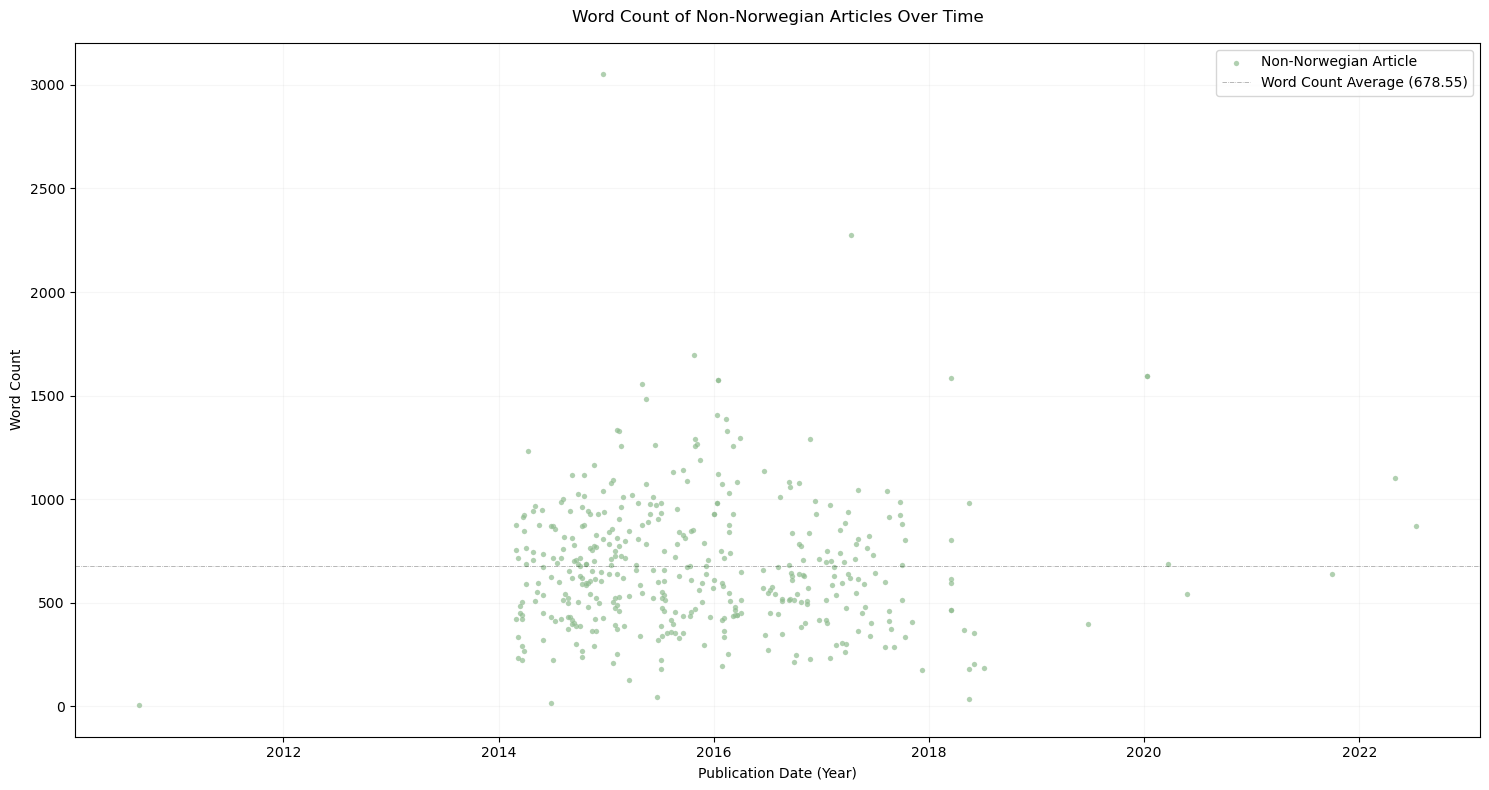

In [163]:
# Filter for non-Norwegian articles
all_df = df.copy()
non_norwegian_df = df[df['is_norwegian'] == False].copy()
df = df[df['is_norwegian']].copy()          # df Dataframe is now only with articles in norwegian


# Create the scatter plot
plt.figure(figsize=(15, 8))

# Plot the word count with small dots
plt.scatter(non_norwegian_df['published'],
        non_norwegian_df['word_count'],
        s=15,
        edgecolors='white',
        linewidths=0.1,
        alpha=0.7,
        color='darkseagreen',
        label='Non-Norwegian Article')

# Add the black line for the overall average of non-Norwegian articles
average_word_count = non_norwegian_df['word_count'].mean()
plt.axhline(average_word_count,
        color='black',
        alpha=0.4,
        linestyle='-.',
        linewidth=0.5,
        label=f'Word Count Average ({average_word_count:.2f})')

# Annotations and Labels
plt.title('Word Count of Non-Norwegian Articles Over Time', fontsize=12, pad=15)
plt.xlabel('Publication Date (Year)', fontsize=10)
plt.ylabel('Word Count', fontsize=10)
plt.grid(True, linestyle='-', alpha=0.1)
plt.legend()
plt.tight_layout()

# Print some statistics
print(f"Total number of non-Norwegian articles: {len(non_norwegian_df)}")
print(f"Average word count: {average_word_count:.2f}")

plt.show()

In [164]:
non_norwegian_df.sample(5)

,bodytext,created_by_name,id,published,published_url,subtitle,tags,title,year,month,day,word_count,word_count_range,is_norwegian,clean_text
12497,"""An avalanche warning system will be a tool fo...","Woldbrand Guldstad, Alexander",136749,2015-02-06 13:32:36+00:00,/avalanches/must-think-for-themselves/136749,Red Cross and and other officials are afraid a...,"nyheter, avalanches",'Must think for themselves',2015,2,6,373,"[0, 500)",False,An avalanche warning system will be a tool for...
11762,"""It was the best we could hope for,"" said Rona...","Woldbrand Guldstad, Alexander",144143,2015-12-31 12:28:00+00:00,/coal-crisis/its-the-best-we-could-hope-for/14...,The union leader at Store Norske is relieved a...,"nyheter, coal crisis",'It's the best we could hope for',2015,12,31,608,"[500, 1000)",False,It was the best we could hope for said Ronald ...
12725,"On Monday of this week, the message everyone w...","Woldbrand Guldstad, Alexander",134492,2014-11-28 08:25:00+00:00,/coal-crisis-store-norske/she-must-make-cuts/1...,"Before Christmas, at least 100 employees at St...","nyheter, store norske, coal crisis",She must make cuts,2014,11,28,826,"[500, 1000)",False,On Monday of this week the message everyone wa...
12650,Norwegian Minister of Justice and Public Secur...,"Woldbrand Guldstad, Alexander",135244,2014-12-19 10:52:28+00:00,/coal-crisis-store-norske/strong-faith-in-a-so...,&#039;But we should not pretend that this is n...,"nyheter, store norske, coal crisis",Strong faith in a solution,2014,12,19,424,"[0, 500)",False,Norwegian Minister of Justice and Public Secur...
12912,Riis has experience from Oslo Mikrobryggeri an...,"Woldbrand Guldstad, Alexander",132714,2014-10-03 09:56:00+00:00,/brewery-svalbard/soon-the-dream-is-a-reality/...,Construction of Svalbard Bryggeri is starting ...,"nyheter, svalbard, brewery",Soon the dream is a reality,2014,10,3,675,"[500, 1000)",False,Riis has experience from Oslo Mikrobryggeri an...


### Parsing

In [165]:
# Parse cleaned norwegian texts
start_time = time.time()
df['parsing'] = df['clean_text'].progress_apply(nlp)
elapsed_time = time.time() - start_time
print(f"Processing completed in {elapsed_time:.2f} seconds.")

100%|██████████| 16298/16298 [06:00<00:00, 45.24it/s]

Processing completed in 360.23 seconds.


### Tokenization

In [166]:
# Creating Lemmas
def clean_tokens(doc):
    """Enhanced token cleaning with Norwegian-specific processing"""
    tokens = []
    for token in doc:
        # Fix the logical operators with proper parentheses
        if (
            (token.pos_ in {"PROPN", "NOUN"} or token.ent_type_ in {"ORG"}) and  # Filter by type
            token.is_alpha and  # Exclude non-alphabetical lemmas
            len(token.lemma_) > 2 and  # Three or more letters
            token.lemma_.lower().strip() not in STOPWORDS  # Check lowercase version
        ):
            # Apply spelling corrections
            lemma = token.lemma_.lower().strip()
            corrected_lemma = SPELLING_CORRECTIONS.get(lemma, lemma)
            if corrected_lemma not in STOPWORDS:  # Double check after correction
                tokens.append(corrected_lemma)
    return tokens

# Apply the enhanced cleaning function to store lemmas as list
df['lemmas'] = df['parsing'].apply(clean_tokens)

# Display the first few rows to verify results
print(df[['parsing', 'lemmas']].sample(5))

                                                 parsing  \
12519  (Billettsalget, har, gått, bra, forhåpentlig, ...   
13923  (Klassen, for, små, spann, ble, suverent, vunn...   
6779   (Dette, bildet, er, tatt, sommeren, og, igjen,...   
1157   (Frem, til, påske, skal, det, leses, noteres, ...   
1758   (Tirsdag, morgen, kom, pressemeldingen, fra, S...   

                                                  lemmas  
12519  [billettsalg, vis, artist, fly, fastland, tekn...  
13923  [klassen, spann, lena, danielsen, fredrik, lin...  
6779   [bilde, sommer, carl, wendt, fotograf, gabriel...  
1157   [påske, klasserom, skole, gjengen, jobb, kåre,...  
1758   [tirsdag, morgen, pressemelding, sysselmestere...  


### Temperature

In [167]:
min_year = df['year'].min()  # Earliest year in the dataset
max_year = df['year'].max()  # Most recent year in the dataset
mid_year = (max_year + min_year) // 2  # Middle year for reference

df['temperature'] = df['year'].apply(lambda year: year - mid_year)  # Difference from the middle year

def year_to_color(year, min_year, max_year):  # Map year to a color gradient (red to blue)
    normalized = (max_year - year) / (max_year - min_year)  # Normalize: older years closer to 0, recent to 1
    return mcolors.to_hex((1 - normalized, 0, normalized))  # Convert normalized value to hex color

df['color'] = df['year'].apply(lambda year: year_to_color(year, min_year, max_year))  # Apply color mapping

df.sample(3)

,bodytext,created_by_name,id,published,published_url,subtitle,tags,title,year,month,day,word_count,word_count_range,is_norwegian,clean_text,parsing,lemmas,temperature,color
9602,Fremskrittspartiet i Longyearbyen ønsker å utd...,"Woldbrand Guldstad, Alexander",163785,2017-11-17 08:29:00+00:00,/leserinnlegg/frp-og-kontantstotte/163785,Fremskrittspartiet i Longyearbyen ønsker å utd...,"meninger, leserinnlegg",FrP og kontantstøtte,2017,11,17,311,"[0, 500)",True,Fremskrittspartiet i Longyearbyen ønsker å utd...,"(Fremskrittspartiet, i, Longyearbyen, ønsker, ...","[fremskrittsparti, kontantstøtte, frp, hverdag...",2,#9c0063
2753,Det går fram av en pressemelding fra Russlands...,"Markussen, Anja Charlotte",492836,2022-10-07 10:36:44+00:00,/nordomradepolitikk-russland/anklager-norge-fo...,Russland anklager Norge for å øke den militære...,"russland, nordområdepolitikk, nyheter",Anklager Norge for økt militært nærvær på Sval...,2022,10,7,142,"[0, 500)",True,Det går fram av en pressemelding fra Russlands...,"(Det, går, fram, av, en, pressemelding, fra, R...","[pressemelding, russland, utenriksdepartement,...",7,#e3001c
5435,"Det er to plasser det kommer inn vann i gruva,...","Woldbrand Guldstad, Alexander",200561,2020-08-17 15:00:00+00:00,/jobber-for-a-unnga-ytterligere-skade/200561,"Det kommer fremdeles inn vann i Gruve 7, og hv...",nyheter,Jobber for å unngå ytterligere skade,2020,8,17,522,"[500, 1000)",True,Det er to plasser det kommer inn vann i gruva ...,"(Det, er, to, plasser, det, kommer, inn, vann,...","[vann, gruve, kontroll, strømforsyning, pump, ...",5,#c60039


### TF-IDF

In [168]:
# Convert lemmas column into a temporary array of strings
lemmas_as_strings = df["lemmas"].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).to_numpy()

# Initialize CountVectorizer with minimum document frequency
vectorizer = CountVectorizer(
    lowercase=False,
    min_df=10,              # Term must appear in at least 10 documents
    max_df=0.90             # Remove terms that appear in more than 90% of documents
)

# Vectorize the lemmas array
X = vectorizer.fit_transform(lemmas_as_strings)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
train_data = tfidf.fit_transform(X)

# Display results
print(f"Vocabulary: {vectorizer.get_feature_names_out()[:10]}")  # First 10 terms
print(f"Shape of the document-term matrix: {X.shape}")
print(f"Shape of the TF-IDF matrix: {train_data.shape}")

Vocabulary: ['aagesen' 'aalberg' 'aarhus' 'aari' 'aars' 'aas' 'aasebø' 'aasen'
 'aasheim' 'aasland']
Shape of the document-term matrix: (16298, 11920)
Shape of the TF-IDF matrix: (16298, 11920)


### UMAP

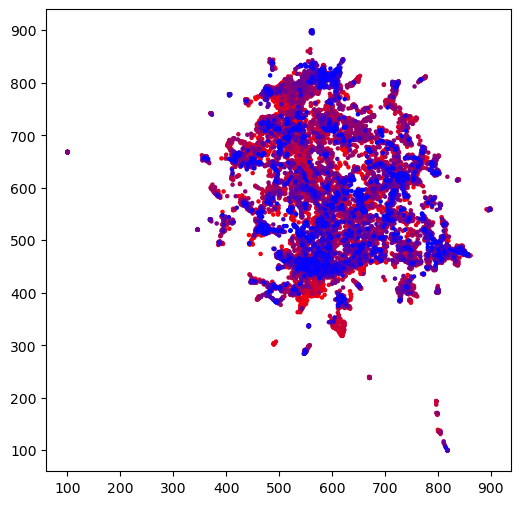

In [169]:
# Suppress the specific UserWarning from UMAP about n_jobs and random_state
warnings.filterwarnings(
    action='ignore',
    message='n_jobs value.*',
    category=UserWarning,
    module='umap'
)

# Define UMAP parameters
umap_params = {
    'random_state': 1,
    'n_components': 2,
    'n_neighbors': 15,  # Adjusted for typical usage
    'min_dist': 0.1,
    'metric': 'hellinger'
}

# Compute UMAP embedding
reducer = umap.UMAP(**umap_params)
embedding = reducer.fit_transform(train_data)

# Scale embeddings
scaler = MinMaxScaler(feature_range=(100, 900))
embedding_scaled = scaler.fit_transform(embedding).astype(int)

# Assign embeddings to 'x' and 'y' in the DataFrame
df["x"], df["y"] = embedding_scaled[:, 0], embedding_scaled[:, 1]

# Adjust the figure size to make the plot smaller
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df["x"], df["y"], s=5, c=df["color"])

### Clustering

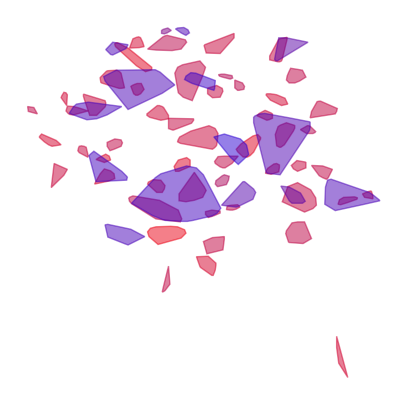

In [170]:
df["cluster"] = "-1"  # Initialize 'cluster' column

hdbscan_params = {
    "min_cluster_size": 50,
    # "min_samples": 4,
    "cluster_selection_epsilon": 0.2,
    # 'metric': 'haversine'
    'cluster_selection_method': 'leaf',
}

# Define conditions and prefixes
conditions = [(df["temperature"] > 0, "p_"), (df["temperature"] <= 0, "n_")]

# Perform clustering and assign labels
for condition, prefix in conditions:
    indices = df.index[condition]
    embedding = df.loc[indices, ["x", "y"]].to_numpy()

    # Initialize and fit the HDBSCAN clusterer with parameters
    clusterer = hdbscan.HDBSCAN(**hdbscan_params)
    labels = clusterer.fit_predict(embedding)

    # Apply prefix to cluster labels
    df.loc[indices, "cluster"] = [
        f"{prefix}{label}" if label != -1 else str(label) for label in labels
    ]

##
## Visualization
##



plt.figure(figsize=(5, 5))
plt.axis("off")

# Get unique cluster labels
clusters = [cluster for cluster in df["cluster"].unique() if cluster != "-1"]

# print(clusters)

for cluster in clusters:
    # Get data for the current cluster
    cluster_data = df[df["cluster"] == cluster]
    cluster_points = cluster_data[["x", "y"]].values
    cluster_colors = cluster_data["color"].values  # Array of colors

    # Need at least 3 points to compute a convex hull
    # if len(cluster_points) < 3:
    #     print(f"Cluster '{cluster}' has less than 3 points ({len(cluster_points)}). Skipping.")
    #     continue

    # Compute the convex hull
    hull = ConvexHull(cluster_points)
    hull_vertices = cluster_points[hull.vertices]

    # Close the hull by appending the first point at the end
    x_hull = np.append(hull_vertices[:, 0], hull_vertices[0, 0])
    y_hull = np.append(hull_vertices[:, 1], hull_vertices[0, 1])

    # Convert colors to RGB format
    rgb_colors = []
    for color in cluster_colors:
        try:
            rgb = mcolors.to_rgb(color)
            rgb_colors.append(rgb)
        except ValueError:
            print(f"Invalid color '{color}' in cluster '{cluster}'. Using default color.")
            rgb_colors.append((0, 0, 0))  # Default to black if color is invalid

    # Compute average RGB values
    avg_rgb = np.mean(rgb_colors, axis=0)

    # Ensure RGB values are within [0, 1]
    avg_rgb = np.clip(avg_rgb, 0, 1)

    # Convert average RGB back to hex color
    avg_color_hex = mcolors.to_hex(avg_rgb)

    # Plot the convex hull with the average color
    plt.fill(x_hull, y_hull, color=avg_color_hex, alpha=0.5)

plt.show()


### Frequency

In [171]:
def get_top_n_words(lemmas_column, n_top_words=30):
    """
    Gets the n most common words and their frequencies from a column with lists of words.

    Args:
        lemmas_column (pd.Series): Column containing lists of words.
        n_top_words (int): Number of most frequent words to return.

    Returns:
        tuple: List of most common words and list of their corresponding frequencies.
    """
    # Flatten all lists into a single list
    all_words = [word for lemmas_list in lemmas_column for word in lemmas_list]
    
    # Count the frequency of each word
    word_counts = Counter(all_words)
    
    # Get the most common words
    most_common = word_counts.most_common(n_top_words)
    
    # Separate words and frequencies
    top_words = [word for word, count in most_common]
    top_counts = [count for word, count in most_common]
    
    return top_words, top_counts


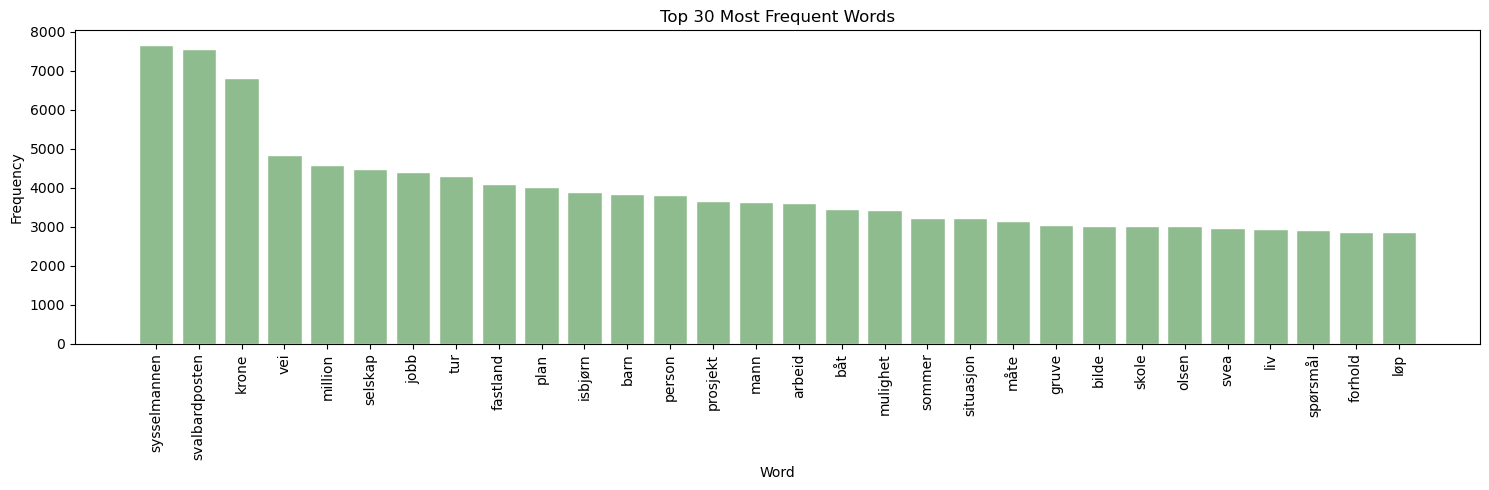

In [172]:
# Get the 30 most common words
n_top_words = 30
top_words, top_counts = get_top_n_words(df['lemmas'], n_top_words=n_top_words)

# Plot the most common words
plt.figure(figsize=(15, 5))
plt.bar(top_words, top_counts, color='darkseagreen', edgecolor='white')
plt.xticks(rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title(f'Top {n_top_words} Most Frequent Words')
plt.tight_layout()
plt.show()


In [173]:

# Extract keywords for each cluster
def extract_keywords(df, top_n=15, max_features=1000):
    results = []

    for cluster_id, group in df.groupby("cluster"):
        # Vectorize the text
        vectorizer = CountVectorizer(max_features=max_features)
        lemmas = group["lemmas"] = group["lemmas"].apply(
            lambda x: " ".join(x) if isinstance(x, list) else str(x)
        )
        # print(group["lemmas"])
        # print(test)
        # print(" ".join(group['lemmas']))
        X = vectorizer.fit_transform(lemmas)

        # Calculate word frequencies
        word_sums = X.sum(axis=0).A1  # Convert matrix to array
        words_freq = sorted(
            ((word, word_sums[idx]) for word, idx in vectorizer.vocabulary_.items()),
            key=lambda x: x[1], reverse=True
        )

        # Get top keywords
        top_keywords = [word for word, _ in words_freq[:top_n]]

        # Append cluster results
        results.append({'cluster': cluster_id, 'top_keywords': top_keywords})

    return pd.DataFrame(results)


# Usage
keywords_df = extract_keywords(df)

keywords_df

,cluster,top_keywords
0,-1,"[sysselmannen, svalbardposten, krone, selskap,..."
1,n_0,"[turn, minutt, deltaker, løp, renn, tur, start..."
2,n_1,"[hund, sysselmannen, dyr, rev, mattilsynet, re..."
3,n_10,"[ålesund, unis, forsker, bay, kings, student, ..."
4,n_11,"[kirke, kjell, helgesen, leif, magne, mork, ve..."
...,...,...
62,p_50,"[bedrift, million, krone, reiseliv, ordning, v..."
63,p_6,"[dei, ein, ikkje, seier, kjem, fleire, mykje, ..."
64,p_7,"[bilde, svalbardposten, post, informasjon, epo..."
65,p_8,"[turn, løype, skimaraton, løp, bakke, johannes..."


### GPT: Topic Label

In [205]:
# Load environment variables
load_dotenv()

# Get API key and initialize client
api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=api_key)

# Initialize a dictionary to store the cluster subjects
cluster_subjects = {}

# Iterate over each cluster in the keywords_df
for cluster_id in keywords_df['cluster'].unique():
    # Get the top keywords for the current cluster
    top_keywords = keywords_df[keywords_df['cluster'] == cluster_id]['top_keywords'].iloc[0]

    # Convert the list of keywords into a string to pass to the API
    keywords_text = ", ".join(top_keywords)

    try:
        # Send the request to the ChatGPT API
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an expert in text analysis, in Norwegian language, and Svalbard with a background in library science and digital humanities."},
                {"role": "user", "content": f"Can you tell me, in two/three words in English, which is the subject of the cluster starting from a list of keywords ordered by frequency? Please avoid any comment, so that we can copy and paste your two/three words immediately. Also avoid punctuation and generic subjects or the words Svalbard, Nordic. This is the list of top keywords for one cluster, in Norvegian: \n\n{keywords_text}"}
            ],
                #{"role": "system", "content": "You are an expert in text analysis and Svalbard with a background in library science. You understand Norwegian language and Svalbard-specific terms. Your task is to provide concise, specific topic labels based on keyword frequencies."},
                #{"role": "user", "content": f"Analyze these Norwegian keywords (ordered by frequency) and provide a single 2-3 word subject label that specifically describes the topic cluster. Please avoid any comment, so that we can copy and paste your two/three words immediately. Also avoid punctuation and generic subjects and don't use the word Svalbard. This is the list of top keywords for one cluster, in Norvegian: \n\n{keywords_text}"}
            max_tokens=50
        )

        # Extract the response content as the subject for this cluster
        subject = response.choices[0].message.content.strip()
    except Exception as e:
        # Handle any API errors
        print(f"Error generating subject for cluster {cluster_id}: {e}")
        subject = "N/A"

    # Store the subject in the dictionary
    cluster_subjects[cluster_id] = subject

# Add the cluster subjects as a new column to the keywords_df
keywords_df['cluster_subject'] = keywords_df['cluster'].map(cluster_subjects)

# Display the keywords_df with the new column
keywords_df

,cluster,top_keywords,cluster_subject
0,-1,"[sysselmannen, svalbardposten, krone, selskap,...",Economic development planning
1,n_0,"[turn, minutt, deltaker, løp, renn, tur, start...",Cross Country Skiing
2,n_1,"[hund, sysselmannen, dyr, rev, mattilsynet, re...",Animal management issues
3,n_10,"[ålesund, unis, forsker, bay, kings, student, ...",Arctic Research Education
4,n_11,"[kirke, kjell, helgesen, leif, magne, mork, ve...",Church Life Community
...,...,...,...
62,p_50,"[bedrift, million, krone, reiseliv, ordning, v...",Business Financial Support
63,p_6,"[dei, ein, ikkje, seier, kjem, fleire, mykje, ...",Snow energy risks
64,p_7,"[bilde, svalbardposten, post, informasjon, epo...",Museum Photography Collection
65,p_8,"[turn, løype, skimaraton, løp, bakke, johannes...",Cross-country Skiing Marathon


In [206]:
# Realizar el merge
df_merged = pd.merge(df, keywords_df, on='cluster', how='left')
df_merged.sample(1)

,bodytext,created_by_name,id,published,published_url,subtitle,tags,title,year,month,...,clean_text,parsing,lemmas,temperature,color,x,y,cluster,top_keywords,cluster_subject
10306,Endelig er solen tilbake til Longyearbyen. Ons...,"Woldbrand Guldstad, Alexander",155770,2017-03-10 06:00:00+00:00,/leder/sol-ute-sol-inne/155770,Det gjør godt å kjenne på de aller første sols...,"meninger, leder","Sol ute, sol inne",2017,3,...,Endelig er solen tilbake til Longyearbyen Onsd...,"(Endelig, er, solen, tilbake, til, Longyearbye...","[sol, onsdag, mars, sol, tilbakekomst, sykehus...",2,#9c0063,811,527,-1,"[sysselmannen, svalbardposten, krone, selskap,...",Economic development planning


In [208]:
# Select desired cluster
selected_cluster = 'p_2'  # Change to the cluster you want

# Filter the DataFrame by cluster
filtered_df = df[df['cluster'] == selected_cluster]

# Select 5 random URLs from the cluster
random_urls = filtered_df.sample(n=5, replace=False, random_state=42) if len(filtered_df) >= 5 else filtered_df

# Display the selected URLs
print(f"Selected cluster: {selected_cluster}")
print("Random URLs:")
print(random_urls['title'].to_list())


Selected cluster: p_2
Random URLs:
['129.500 kroner skiller auksjonens billigste og dyreste objekt', 'Vinnerskinn merkes med mikrochip', 'Startskudd for TV-aksjonen går denne helgen', 'TV-auksjonen fikk inn over 500 000', 'Stort bidrag til UNICEF']


### Polarization

In [209]:
# Download the resource if it's not already available
nltk.download('opinion_lexicon')

# Lists of positive and negative words
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Example
print(f"Total positive words: {len(positive_words)}")
print(f"Total negative words: {len(negative_words)}")

Total positive words: 2006
Total negative words: 4783


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/tina/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [210]:
# Function to compute metrics for each text
def analyze_polarization(text):
    words = text.lower().split()
    word_count = Counter(words)
    positives = sum(word_count[word] for word in positive_words if word in word_count)
    negatives = sum(word_count[word] for word in negative_words if word in word_count)
    
    # Narrative tension (total emotional words)
    tension = positives + negatives
    
    # Balance (minimum between positives and negatives)
    balance = min(positives, negatives)
    
    # Polarization: Proportion of balance relative to tension
    polarization = balance / tension if tension > 0 else 0
    
    return positives, negatives, tension, balance, polarization

# Apply the function to each text and decompose the results into separate columns
df_merged[['positives', 'negatives', 'tension', 'balance', 'polarization']] = df_merged['bodytext'].apply(
    lambda x: pd.Series(analyze_polarization(x))
)

# Group by cluster and cluster_subject, and calculate aggregate metrics
cluster_summary = df_merged.groupby(['cluster', 'cluster_subject']).agg({
    'positives': 'sum',
    'negatives': 'sum',
    'tension': 'sum',
    'balance': 'sum',
    'polarization': 'mean'  # Average polarization
}).reset_index()

# Sort clusters by polarization
cluster_summary = cluster_summary.sort_values(by='tension', ascending=False)

# Print the summary
cluster_summary.head(5)

,cluster,cluster_subject,positives,negatives,tension,balance,polarization
0,-1,Economic development planning,5279.0,6320.0,11599.0,2395.0,0.081597
52,p_41,Russian settlements,346.0,203.0,549.0,109.0,0.117937
3,n_10,Arctic Research Education,187.0,306.0,493.0,91.0,0.081426
6,n_13,Emergency rescue operations,275.0,189.0,464.0,64.0,0.033427
59,p_48,Polar Tourism Regulation,207.0,235.0,442.0,94.0,0.113819


## Save

In [211]:
# Assuming df_merged and cluster_summary are the two datasets
df_combined = df_merged.merge(cluster_summary, on="cluster", how="inner")
df_combined = df_combined.drop(columns=["bodytext", "parsing", "lemmas"])
df_combined = df_combined[df_combined['cluster'] != '-1'] # remove cluster -1

# Display the merged dataset
df_combined.sample(1)
df_combined.to_csv("../src/data/entities.csv", index=False)